# Toy Spectral Cube Visualization

This notebook provides visualization tools for analyzing 3D Integral Field Unit (IFU) spectral cubes, specifically designed for mock galaxy observations. 

## Overview

The notebook demonstrates:
- **Moment map generation**: Creates moment 0 (integrated flux) and moment 1 (velocity-weighted) maps
- **Velocity spectrum plotting**: Displays 1D flux vs velocity profiles
- **Resolution comparison**: Analyzes differences between resolved and unresolved observations
- **Beam convolution effects**: Simulates telescope point spread function
- **Dendrogram masking**: Identifies significant emission regions for robust analysis

## Key Features

- **Beam convolution**: Applies realistic telescope resolution effects using `convolve_beam()`
- **Spectral smoothing**: Uses Gaussian filtering to improve signal-to-noise ratio
- **Dendrogram analysis**: Employs `astrodendro` for structure identification and masking
- **Automated visualization**: Generates publication-ready figures with proper scaling and annotations
- **Physical units**: All outputs include proper astronomical units (Jy/beam, km/s, kpc)

## Output

The notebook generates:
- PDF figures for moment maps and velocity spectra
- Diagnostic information about spatial resolution and integrated flux
- Comparative analysis between different resolution scenarios

Perfect for understanding observational biases in IFU surveys and developing denoising algorithms that preserve physical galaxy properties.

1959

[ § Creating 2 highly resolved cubes of dimensions 39.2 (spectral) x 80 x 80 (spatial) § ]


[ § Creating 2 highly resolved cubes of dimensions 39.2 (spectral) x 80 x 80 (spatial) § ]

Time taken: 10.632510900497437 seconds
4 0.8333333333333334
3.3333333333333335


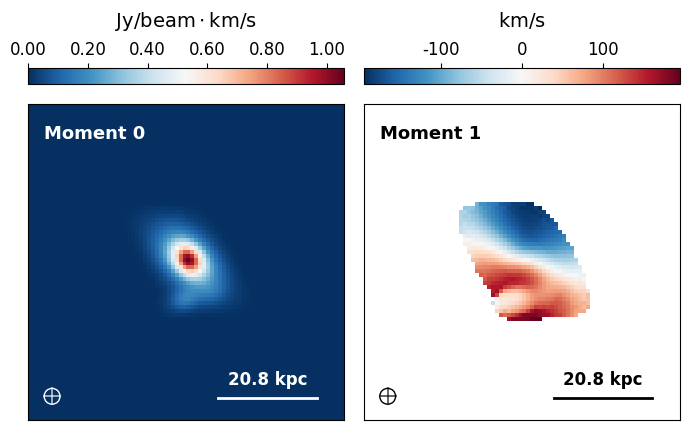

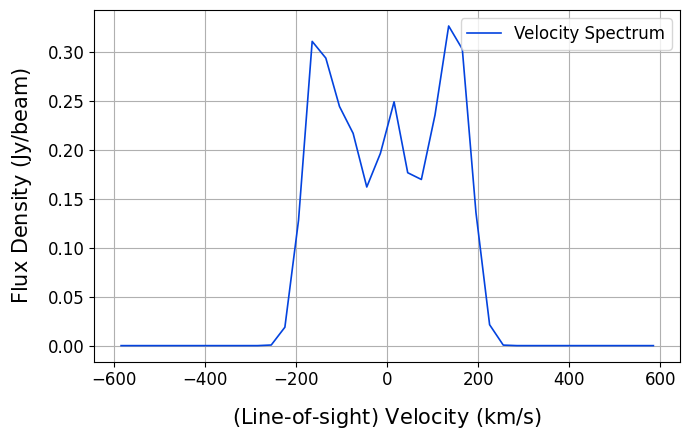

Sum of cube flux: 3.193
4 4.166666666666667
16.666666666666668


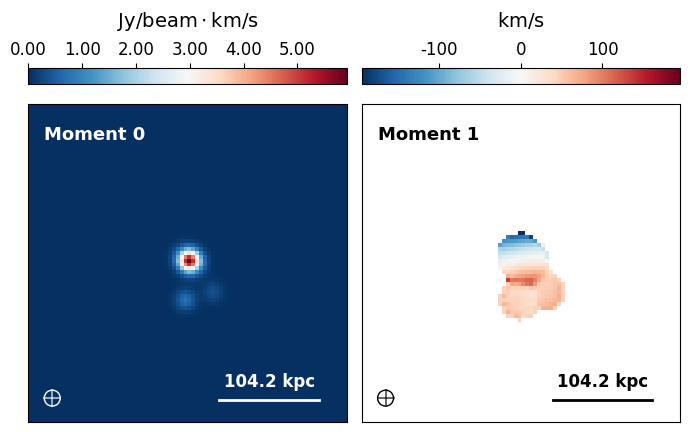

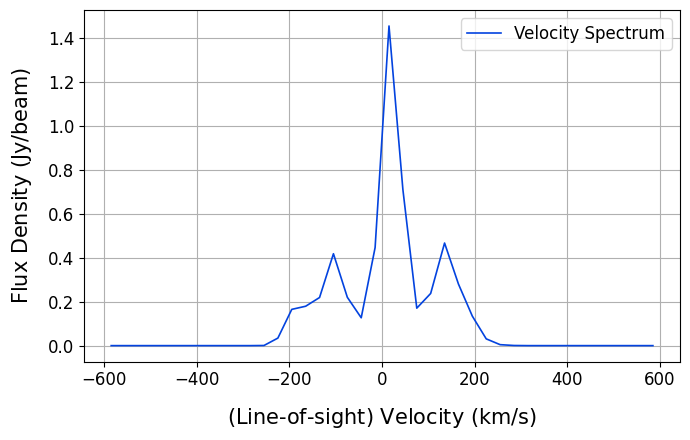

Sum of cube flux: 5.304


In [ ]:
# Local utility functions for IFU processing
import sys
import os
sys.path.append(os.path.abspath('/Users/arnablahiry/repos/3D_IFU_Denoising/src'))
from functions import *              # Custom beam handling and noise simulation tools

# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter1d
from astrodendro import Dendrogram
from src.toy_cube_dataset import *
import time


def plot_moments_and_spectrum(dataset, case, beam_size, scalebar=25, fname_prefix='/Users/arnablahiry/repos/3D_IFU_Denoising/figures/'):
    """
    Generate comprehensive visualizations of spectral cube data including moment maps and velocity spectra.
    
    This function processes a 3D spectral cube to create publication-quality visualizations:
    - Moment 0 map: Integrated flux showing spatial distribution of emission
    - Moment 1 map: Velocity-weighted map revealing kinematic structure
    - Velocity spectrum: 1D profile showing flux as a function of line-of-sight velocity
    
    The function applies beam convolution, spectral smoothing, and dendrogram-based masking
    to enhance the scientific analysis of galaxy emission structures.
    
    Parameters
    ----------
    dataset : list
        Spectral cube dataset containing:
        - dataset[0][0] : numpy.ndarray, shape (n_velocity, n_y, n_x)
            3D spectral cube with velocity as the first axis
        - dataset[0][1] : dict
            Metadata dictionary containing:
            * 'average_vels' : numpy.ndarray
                Velocity array corresponding to spectral channels
            * 'pix_spatial_scale' : float
                Spatial scale per pixel in kpc
    case : str
        Identifier for the dataset type (e.g., 'resolved', 'unresolved').
        Used in output filenames to distinguish different analysis cases.
    beam_size : float
        Size of the telescope beam in pixels for convolution. Simulates the
        point spread function of the observing instrument.
    scalebar : int, optional
        Length of the scale bar displayed on maps in pixels (default: 25).
        Provides physical size reference on the spatial maps.
    fname_prefix : str, optional
        Directory path prefix for saving output figures (default: 'figures/').
        Files are saved as PDF format with descriptive names.
    
    Returns
    -------
    tuple
        (cube_shape, pixel_scale) where:
        - cube_shape : tuple
            Dimensions of the processed cube (n_velocity, n_y, n_x)
        - pixel_scale : float
            Spatial scale per pixel in kpc/pixel
    
    Notes
    -----
    Processing pipeline:
    1. Beam convolution using specified beam size
    2. Spectral smoothing with Gaussian filter (σ=0.6 channels)
    3. Velocity rebinning (5:1 ratio) to improve signal-to-noise
    4. Dendrogram-based masking to identify significant emission regions
    5. Moment calculations with proper masking to avoid noise bias
    6. Figure generation with colorbars, scale bars, and beam indicators
    
    The dendrogram masking uses thresholds of 0.25σ (min_value) and 1σ (min_delta)
    where σ is the standard deviation of the convolved cube. This helps identify
    genuine emission structures while suppressing noise artifacts.
    
    Output files:
    - moment_maps_{case}.pdf: Side-by-side moment 0 and moment 1 maps
    - velocity_spectrum_{case}.pdf: 1D velocity profile
    
    Examples
    --------
    >>> # Generate visualizations for a resolved galaxy dataset
    >>> shape, scale = plot_moments_and_spectrum(resolved_data, 'resolved', 
    ...                                          beam_size=4, scalebar=25)
    >>> print(f"Spatial resolution: {4 * scale:.2f} kpc")
    """


    cube = dataset[0][0]
    convolved_cube = convolve_beam(cube, beam_size)
    convolved_cube = gaussian_filter1d(convolved_cube, sigma=0.6, axis=0)
    
    vels = dataset[0][1]['average_vels']
    vels = vels.reshape(vels.shape[0]//5, 5).mean(axis=1)
    pix_spatial_scale = dataset[0][1]['pix_spatial_scale']
    del_V = np.diff(vels).mean()
    moment_cube = convolved_cube * vels[:, np.newaxis, np.newaxis]
    
    # Compute mask using dendrogram
    mask = np.zeros(convolved_cube.shape, dtype=bool)
    dendro = Dendrogram.compute(convolved_cube, min_value=0.25*convolved_cube.std(),
                                min_delta=convolved_cube.std(), verbose=False)
    for trunk in dendro.trunk:
        mask |= trunk.get_mask()
    
    # Image extent
    ny, nx = cube.shape[1], cube.shape[2]
    extent = [0, nx, 0, ny]
    
    # Plot moment maps
    fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)
    
    # Moment 0
    im0 = ax[0].imshow(convolved_cube.sum(axis=0)*del_V, cmap='RdBu_r', origin='lower', extent=extent)
    divider0 = make_axes_locatable(ax[0])
    cax0 = divider0.append_axes("top", size="5%", pad=0.2)
    #cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', label=r'$\rm Jy\,beam^{-1} \cdot km\,s^{-1}$', format='%.2f')
    cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', label=r'$\rm Jy/beam \cdot km/s$', format='%.2f')
    cb0.ax.xaxis.set_label_position('top')
    cb0.ax.xaxis.set_ticks_position('top')
    cb0.ax.xaxis.label.set_size(14)
    cb0.ax.tick_params(labelsize=12)
    cb0.ax.xaxis.labelpad = 10
    ax[0].text(nx * 0.05, ny * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
    add_beam(ax[0], beam_size, beam_size, 0, xy_offset=(6,6), color='white')
    
    # Moment 1
    numerator = (mask * moment_cube).sum(axis=0)
    denominator = (mask * convolved_cube).sum(axis=0)
    ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
    vmax = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
    im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-vmax, vmax=vmax)
    divider1 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes("top", size="5%", pad=0.2)
    #cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', label=r'$\rm km\,s^{-1}$', format='%.0f')
    cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', label=r'$\rm km/s$', format='%.0f')
    cb1.ax.xaxis.set_label_position('top')
    cb1.ax.xaxis.set_ticks_position('top')
    cb1.ax.tick_params(labelsize=12)
    cb1.ax.xaxis.label.set_size(14)
    cb1.ax.xaxis.labelpad = 10
    ax[1].text(nx * 0.05, ny * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
    add_beam(ax[1], beam_size, beam_size, 0, xy_offset=(6,6), color='black')
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_aspect('equal')
    
    # Scalebar
    x0, y0 = nx*0.6, ny*0.07
    for i, color in zip([0,1], ['white','black']):
        ax[i].plot([x0, x0+scalebar], [y0, y0], color=color, lw=2)
        ax[i].text(x0+scalebar/2, y0 + ny*0.03, f'{scalebar*pix_spatial_scale:.1f} kpc',
                   color=color, ha='center', va='bottom', fontsize=12, weight='bold')
        
    print(beam_size, pix_spatial_scale)
    print(beam_size*pix_spatial_scale)
    
    plt.tight_layout()
    plt.savefig(f'{fname_prefix}moment_maps_{case}.pdf', bbox_inches='tight')
    plt.show()
    
    # Velocity spectrum
    plt.figure(figsize=(7,4.5))
    plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
    #plt.ylabel(r'Flux Density ($\rm Jy\,beam^{-1}$)', fontsize=15, labelpad=10)
    plt.ylabel(r'Flux Density ($\rm Jy/beam$)', fontsize=15, labelpad=10)
    #plt.xlabel(r'(Line-of-sight) Velocity ($\rm km\,s^{-1}$)', fontsize=15, labelpad=12)
    plt.xlabel(r'(Line-of-sight) Velocity ($\rm km/s$)', fontsize=15, labelpad=12)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.grid(True)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.savefig(f'{fname_prefix}velocity_spectrum_{case}.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"Sum of cube flux: {np.sum(convolved_cube):.3f}")
    return convolved_cube.shape, pix_spatial_scale


start = time.time()
n_gals = 3
offset_gals = 15
n_cubes = 2
init_grid_size= 31
final_grid_size=80
n_spectral_slices=40
beam_size = 4


seed = 1959 #np.random.randint(0, 10000) #6194 # #
case1 = 'resolved'
case2 = 'unresolved'
print(seed)

resolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case1,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)

unresolved_dataset = ResolvedSpectralCubeDataset(n_gals = n_gals, resolution=case2,offset_gals=offset_gals, beam_size=beam_size,
                                               n_cubes=n_cubes, init_grid_size= init_grid_size, final_grid_size=final_grid_size,
                                               n_spectral_slices=n_spectral_slices, verbose=False, plot=False, seed=seed)


stop = time.time()
print(f'Time taken: {stop - start} seconds')    



for case, dataset, beam_size in zip(['resolved','unresolved'],
                                    [resolved_dataset, unresolved_dataset],
                                    [beam_size, beam_size]):
    plot_moments_and_spectrum(dataset, case, beam_size)
